# Linear Regression

### Imports

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import KFold

import common code (utils)

In [21]:
import sys
from pathlib import Path

# Get current notebook directory
current_dir = Path.cwd()

# Move up until we find 'src'
for parent in current_dir.parents:
    if parent.name == "src":
        sys.path.append(str(parent))
        break
else:
    raise RuntimeError("Could not find 'src' directory")

from common import utils

In [22]:
RANDOM_STATE = 42

### Data Preparation

In [23]:
# Load the CUP training data
ids, X, y = utils.load_cup_data(train=True)

# Split: 90% Development, 10% Internal Test
# We use the same random_state as other group members to ensure consistent splits
X_dev, X_test_internal, y_dev, y_test_internal = utils.split_data(X, y, random_state=RANDOM_STATE)

print(f"Total samples: {len(X)}")
print(f"Development Set shape: {X_dev.shape} (Used for Model Selection)")
print(f"Internal Test Set shape: {X_test_internal.shape} (Used ONLY for final check)")

Total samples: 500
Development Set shape: (450, 12) (Used for Model Selection)
Internal Test Set shape: (50, 12) (Used ONLY for final check)


### Grid search + 5-fold cross-validation

Linear Regression attempts to model the relationship between the 12 input features and the 4 targets by fitting a **linear equation** to the observed data.

**Problem**: In normal Linear Regression, the model tries to minimize only the prediction error, which can lead to very large weights, which makes the model unstable and overfits the training data.

To fix this problem, we use Ridge Regression, which penalizes large weights.

Ridge Regression minimizes this objective:

$$
\text{Loss} = \text{MSE} + \alpha \sum_i w_i^2
$$

* **MSE** → prediction error
* **( \sum w_i^2 )** → L2 penalty on the weights
* **α (alpha)** → regularization strength


- $\alpha = 0$: Same as standard Linear Regression.
- High $\alpha$: Stronger regularization, smaller weights (underfitting).

As a safe initial range for alpha, we chose the logarithmic scale since its well-established and used in the practice. And because the order of magnitude matters more than small differences, for example:

- α = 0.001 and α = 0.01 behave very differently
- α = 0.001 and α = 0.0012 behave almost the same

In [ ]:
# Hyperparameters to study

# We explore alpha values on a logarithmic scale
# alpha = 0.0 → equivalent to standard Linear Regression
# Larger alpha → stronger regularization
alpha_values = [0, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# This list will store the average validation MEE for each alpha value
results = []

print("Starting Grid Search for Ridge Regression...")

# GRID SEARCH LOOP
for alpha in alpha_values:

    # This list stores the MEE for each fold
    fold_mees = []
    
    # Cross-Validation Loop
    for train_index, val_index in kf.split(X_dev):
        # 1. SPLIT DATA INTO TRAIN AND VALIDATION SETS

        # Training data for this fold
        X_fold_train = X_dev.iloc[train_index]
        y_fold_train = y_dev.iloc[train_index]
        
        # Validation data for this fold
        X_fold_val = X_dev.iloc[val_index]
        y_fold_val = y_dev.iloc[val_index]
        
        # 2. NORMALIZATION

        # Create a scaler that normalizes inputs and outputs
        scaler = utils.CupScaler()

        # Fit the scaler ONLY on the training data and normalize training inputs and targets
        X_train_sc, y_train_sc = scaler.fit_transform(X_fold_train, y_fold_train)

        # Normalize validation inputs using the SAME scaler
        # (no fitting here to avoid data leakage)
        X_val_sc, _ = scaler.transform(X_fold_val) # y_val not needed scaled for prediction
        
        # 3. TRAIN THE MODEL

        # If alpha = 0, we use standard Linear Regression
        # Otherwise, we use Ridge Regression with L2 regularization
        if alpha == 0:
            model = LinearRegression()
        else:
            model = Ridge(alpha=alpha)
            
        # Train the model on scaled training data
        model.fit(X_train_sc, y_train_sc)
        
        # 4. PREDICT ON VALIDATION SET (OUTPUT IS SCALED)
        y_pred_sc = model.predict(X_val_sc)
        
        # 5. Inverse Transform Predictions (Back to Original Scale)
        y_pred_original = scaler.inverse_transform_y(y_pred_sc)
        
        # 6. Compute Error (MEE) in Original Space
        fold_mee = utils.mean_euclidean_error(
            y_true=y_fold_val,
            y_pred=y_pred_original
        )

        # Store MEE for this fold
        fold_mees.append(fold_mee)
    
    # Average MEE across the 5 folds and store result
    avg_mee = np.mean(fold_mees)
    results.append({
        'alpha': alpha, 
        'mee': avg_mee
    })

print("Grid Search Complete.")

# Print results
print("Grid Search Results:")
for result in results:
    print(f"Alpha: {result['alpha']}, MEE: {result['mee']:.4f}")

Starting Grid Search for Ridge Regression...
Grid Search Complete.
Grid Search Results:
Alpha: 0, MEE: 25.9364
Alpha: 0.001, MEE: 25.9362
Alpha: 0.01, MEE: 25.9347
Alpha: 0.1, MEE: 25.9198
Alpha: 1.0, MEE: 25.8034
Alpha: 10.0, MEE: 25.5070
Alpha: 100.0, MEE: 25.4092
Alpha: 1000.0, MEE: 25.8407


### Plotting Results

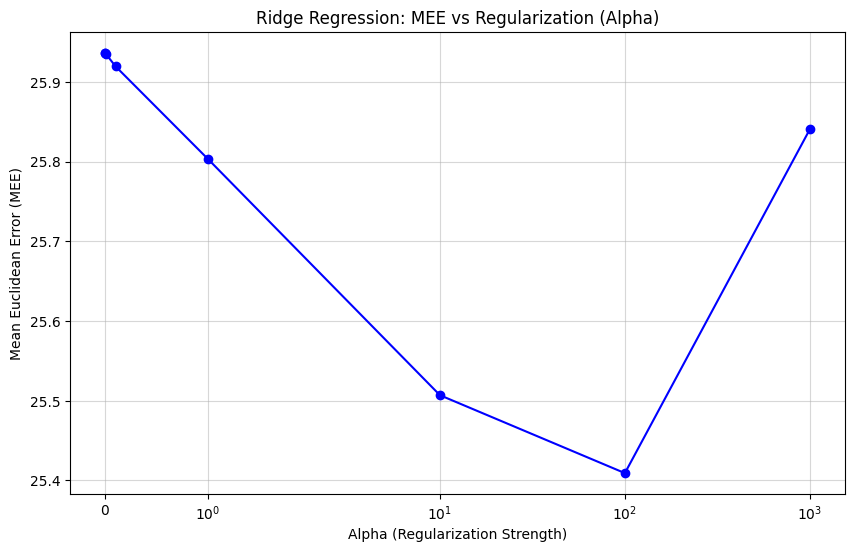

In [25]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot MEE vs Alpha (Log Scale for x-axis)
plt.figure(figsize=(10, 6))
plt.plot(results_df['alpha'], results_df['mee'], marker='o', linestyle='-', color='b')

plt.xscale('symlog') # Symmetric log allows plotting 0 along with log values
plt.title('Ridge Regression: MEE vs Regularization (Alpha)')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Mean Euclidean Error (MEE)')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

### Best Model

In [26]:
# Identify the Best Hyperparameters
best_row = results_df.loc[results_df['mee'].idxmin()]
best_alpha = best_row['alpha']
best_val_mee = best_row['mee']

print(f"BEST CONFIGURATION: Alpha={best_alpha}")
print(f"Best Validation MEE: {best_val_mee:.4f}")

BEST CONFIGURATION: Alpha=100.0
Best Validation MEE: 25.4092


**Best Model on Internal Test Data:** After selecting the best model using cross-validation, we want to know how well does it perform on unseen data?

Before we test it on the final test data, we want to test it on our internal test data that we separated when we first started. We do this by:

- Retraining the selected model on all development data
- Evaluating once on the internal test set
- Reporting final results

In [28]:
# 1. RETRAIN THE FINAL MODEL ON THE FULL DEVELOPMENT SET

# Create a new scaler for inputs and outputs
final_scaler = utils.CupScaler()

# Fit the scaler on the entire development set and normalize both inputs (X_dev) and targets (y_dev)
X_dev_sc, y_dev_sc = final_scaler.fit_transform(X_dev, y_dev)

# Choose which linear model to use based on the selected alpha
if best_alpha == 0:
    final_model = LinearRegression()
else:
    final_model = Ridge(alpha=best_alpha)
    
# Train the final model on the FULL development set
final_model.fit(X_dev_sc, y_dev_sc)

# 2. COMPUTE TRAINING ERROR
y_train_pred_sc = final_model.predict(X_dev_sc)  # Predictions on training set (scaled)
y_train_pred_original = final_scaler.inverse_transform_y(y_train_pred_sc)  # Back to original scale
train_mee = utils.mean_euclidean_error(y_dev, y_train_pred_original)  # Training MEE

# 3. EVALUATE THE MODEL ON THE INTERNAL TEST SET

# Normalize the internal test inputs using the SAME scaler (no refitting here)
X_test_sc, _ = final_scaler.transform(X_test_internal) 

# Predict the outputs for the test set
y_test_pred_sc = final_model.predict(X_test_sc)

# Convert predictions back to the ORIGINAL target scale
y_test_pred_original = final_scaler.inverse_transform_y(y_test_pred_sc)

# Compute the Mean Euclidean Error (MEE) on the test set
test_mee = utils.mean_euclidean_error(y_test_internal, y_test_pred_original)

# 4. FINAL REPORT
print("-" * 40)
print(f"FINAL REPORT (Linear Model / Ridge)")
print("-" * 40)
print(f"Selected Alpha:           {best_alpha}")
print(f"Training MEE:             {train_mee:.4f}")
print(f"Validation MEE (CV):      {best_val_mee:.4f}")
print(f"Internal Test MEE:        {test_mee:.4f}")
print("-" * 40)


----------------------------------------
FINAL REPORT (Linear Model / Ridge)
----------------------------------------
Selected Alpha:           100.0
Training MEE:             25.1940
Validation MEE (CV):      25.4092
Internal Test MEE:        26.6766
----------------------------------------
